In [14]:
"""
Model
"""

import os
import csv
import math
import numpy as np
import cv2
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Activation, Dropout, Conv2D, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

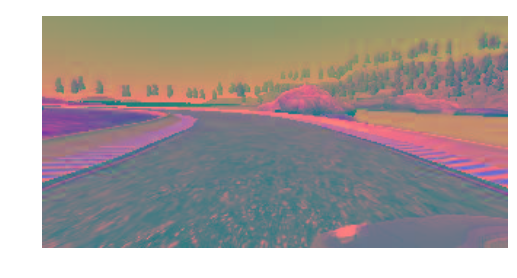

In [24]:
IMG_DIR = 'data/IMG/'
image_shape = (160,320,3)

def showImage(img):
    plt.figure()
    plt.axis('off')
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    plt.imshow(yuv)

showImage(cv2.imread(os.path.join(IMG_DIR, 'left_2016_12_01_13_35_18_632.jpg')))
#showImage(cv2.imread(os.path.join(IMG_DIR, 'center_2016_12_01_13_35_18_632.jpg')))
#showImage(cv2.imread(os.path.join(IMG_DIR, 'right_2016_12_01_13_35_18_632.jpg')))

In [ ]:
LABELS_FILENAME = 'data/driving_log.csv'

def DataGenerator():
    while True:
        with open(LABELS_FILENAME, 'r') as labels_file:
            rdr=csv.DictReader(labels_file)
            for row in rdr:
                img = cv2.imread(os.path.join('data',row['center']))
                img = cv2.cvtColor(img, cv2.CV_BGR2YCrCb)
                X = img.reshape(1,*image_shape)
                y = np.array(float(row['steering']), ndmin=1, dtype=np.float)
                yield (X, y)

numRows = 0
with open(LABELS_FILENAME, 'r') as labels_file:
    rdr=csv.DictReader(labels_file)
    for row in rdr:
        numRows += 1 
print(numRows)

In [ ]:
MODEL_FILE = 'data/model.h5'
if os.path.exists(MODEL_FILE):
    print("Loading from file")
    model = load_model(MODEL_FILE)
else:
    print("Creating model")
    model = Sequential()

    model.add(Conv2D(3, 5, 5, input_shape=image_shape))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(24, 5, 5, input_shape=image_shape))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(36, 5, 5, input_shape=image_shape))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, 3, 3, input_shape=image_shape))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Conv2D(64, 3, 3, input_shape=image_shape))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='softmax'))

model.summary()


In [ ]:
# TODO: Compile and train the model here.
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit_generator(DataGenerator(), samples_per_epoch=numRows * 10, nb_epoch=1, verbose=1, max_q_size=50)

In [ ]:
model.save(MODEL_FILE)